Traitement des donn√©es manquantes : Analyse comparative des m√©thodes d'imputation

Dans cette partie, nous √©tudions deux approches pour g√©rer les donn√©es manquantes :
1. La suppression compl√®te des observations avec donn√©es manquantes
2. L'imputation adapt√©e selon le type de variable :
    - Pour les variables quantitatives : imputation par la m√©diane
    - Pour les variables qualitatives : imputation par le mode

Notre objectif est de construire un mod√®le capable de pr√©dire les h√©morragies du post-partum (HPP) n√©cessitant une transfusion, 
identifi√©es par la variable hpp_trans. Face √† ce probl√®me de classification binaire d√©s√©quilibr√©, 
nous avons choisi le score F1 comme m√©trique d'√©valuation.

L'√©valuation des strat√©gies d'imputation sera r√©alis√©e √† travers trois mod√®les de classification :
- Un mod√®le de r√©gression logistique
- Un mod√®le de for√™ts al√©atoires
- Un mod√®le XGBoost

Les param√®tres par d√©faut seront conserv√©s pour chaque mod√®le.

In [1]:
# Biblioth√®ques standards
import logging
import os

# Biblioth√®ques de donn√©es et calcul scientifique
import joblib
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# MLflow
import mlflow
import mlflow.data.pandas_dataset
import mlflow.sklearn

# Scikit-learn - Pr√©traitement
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Scikit-learn - Mod√©lisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                   StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline

# Scikit-learn - M√©triques
from sklearn.metrics import (ConfusionMatrixDisplay, auc, classification_report,
                           f1_score, make_scorer, precision_recall_curve,
                           precision_score, recall_score, roc_auc_score,
                           roc_curve)

# Imbalanced-learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier


In [2]:
df_dico = pd.read_csv('Project/clean/description_variable_clean.csv',index_col=0)
df_model = pd.read_csv('Project/clean/Bourgogne20132023_clean.csv', index_col=0)

In [3]:
df_model.head()

age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
0   28.0          NaN   NaN      0     NaN        0        0           0   
1   27.0        178.0  23.4      0     0.0        0        0           0   
2   36.0        167.0  22.2      0     2.0        0        0           0   
3   35.0        159.0  17.0      0     0.0        0        0           0   
4   30.0          NaN   NaN      0     NaN        0        0           0   

   preecl  hellp  ...  cortico     AMP  pma  hosp_m_g dsm_g  bilan  nbilan  \
0       0      0  ...        0  Aucune    0         1   2.0      0       0   
1       0      0  ...        0  Aucune    0         1   2.0      0       0   
2       0      0  ...        0  Aucune    0         1   1.0      0       0   
3       0      0  ...        0  Aucune    0         0   0.0      0       0   
4       0      0  ...        0  Aucune    0         2   5.0      0       0   

   nsej18  terme  hpp_trans  
0       1   39.9          0  
1       0   41.6          0  
2       0   41.2          0  
3       0   38.6          0  
4       1   39.9          0  

[5 rows x 23 columns]

In [4]:
# Fonction pour mettre √† jour les listes de features en fonction du dictionnaire de variables
def update_list_features(X_train, df_dico):
    df_dico = df_dico.reindex(X_train.columns)
    quant_features = df_dico[df_dico['type_var'] == 'Quantitative'].index.tolist()
    binary_features = df_dico[df_dico['type_var'] == 'Binaire'].index.tolist()
    nominal_features = df_dico[df_dico['type_var'] == 'Nominale'].index.tolist()
    ordinal_features = df_dico[df_dico['type_var'] == 'Ordinale'].index.tolist()
    return quant_features, binary_features, nominal_features, ordinal_features

In [5]:
### Dataset sans suppression des lignes comportant des valeurs manquantes.

X=df_model.drop(['hpp_trans'],axis=1)
y=df_model["hpp_trans"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

quant_features, binary_features, nominal_features, ordinal_features = update_list_features(X_train, df_dico)

print('Nombre de lignes et de colonnes de X_train : ',X_train.shape,'\n')


print(X_train[:5])

print("Quantitative features : ",quant_features)
print("Binaire features : ",binary_features)
print("Nominal features : ",nominal_features)
print("Ordinale features : ",ordinal_features)



Nombre de lignes et de colonnes de X_train :  (52427, 22) 

       age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
15263   29.0        163.0  30.9      0     1.0        0        0           0   
30669   28.0        169.0  30.1      1     2.0        0        0           0   
9685    48.0        163.0  21.5      0     1.0        0        0           0   
13052   30.0          NaN   NaN      0     NaN        0        0           0   
31781   38.0        160.0  29.3      0     1.0        0        0           0   

       preecl  hellp  ...  ut_cica  cortico     AMP  pma hosp_m_g  dsm_g  \
15263       0      0  ...        1        0  Aucune    0        0    0.0   
30669       0      0  ...        0        0  Aucune    0        0    0.0   
9685        0      0  ...        0        0  Aucune    1        0    0.0   
13052       0      0  ...        0        0  Aucune    0        0    0.0   
31781       0      0  ...        0        0  Aucune    0        0    0.0   

  

In [6]:
### Dataset avec suppression des lignes comportant des valeurs manquantes.

df_model_dropna=df_model.copy().dropna()

X_dropna=df_model_dropna.drop(['hpp_trans'],axis=1)
y_dropna = df_model_dropna["hpp_trans"]


X_train_dropna, X_test_dropna, y_train_dropna, y_test_dropna = train_test_split(X_dropna, y_dropna, test_size=0.20, stratify=y_dropna, random_state=42)

print('Nombre de lignes et de colonnes de X_train : ',X_train_dropna.shape,'\n')


Nombre de lignes et de colonnes de X_train :  (42350, 22) 



In [7]:
def train_evaluate_model_imputation(model):
    # Construction du pipeline
    # Cr√©ation des transformateurs pour chaque type de variable
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

    nominal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Cr√©ation du preprocesseur avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, quant_features),
            ('bin', binary_transformer, binary_features),
            ('nom', nominal_transformer, nominal_features),
            ('ord', ordinal_transformer, ordinal_features)
        ])

    # Pipeline complet avec le mod√®le
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entra√Ænement du mod√®le
    pipeline.fit(X_train, y_train)

    return pipeline

In [8]:
def train_evaluate_model_dropna(model):
    # Cr√©ation des transformateurs pour chaque type de variable
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])

    # Cr√©ation du preprocesseur avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, quant_features),
            ("bin", "passthrough", binary_features), 
            ('nom', nominal_transformer, nominal_features),
            ('ord', ordinal_transformer, ordinal_features)
        ])

    # Pipeline complet avec le mod√®le
    pipeline_dropna = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entra√Ænement du mod√®le
    pipeline_dropna.fit(X_train_dropna, y_train_dropna)
    
    return pipeline_dropna

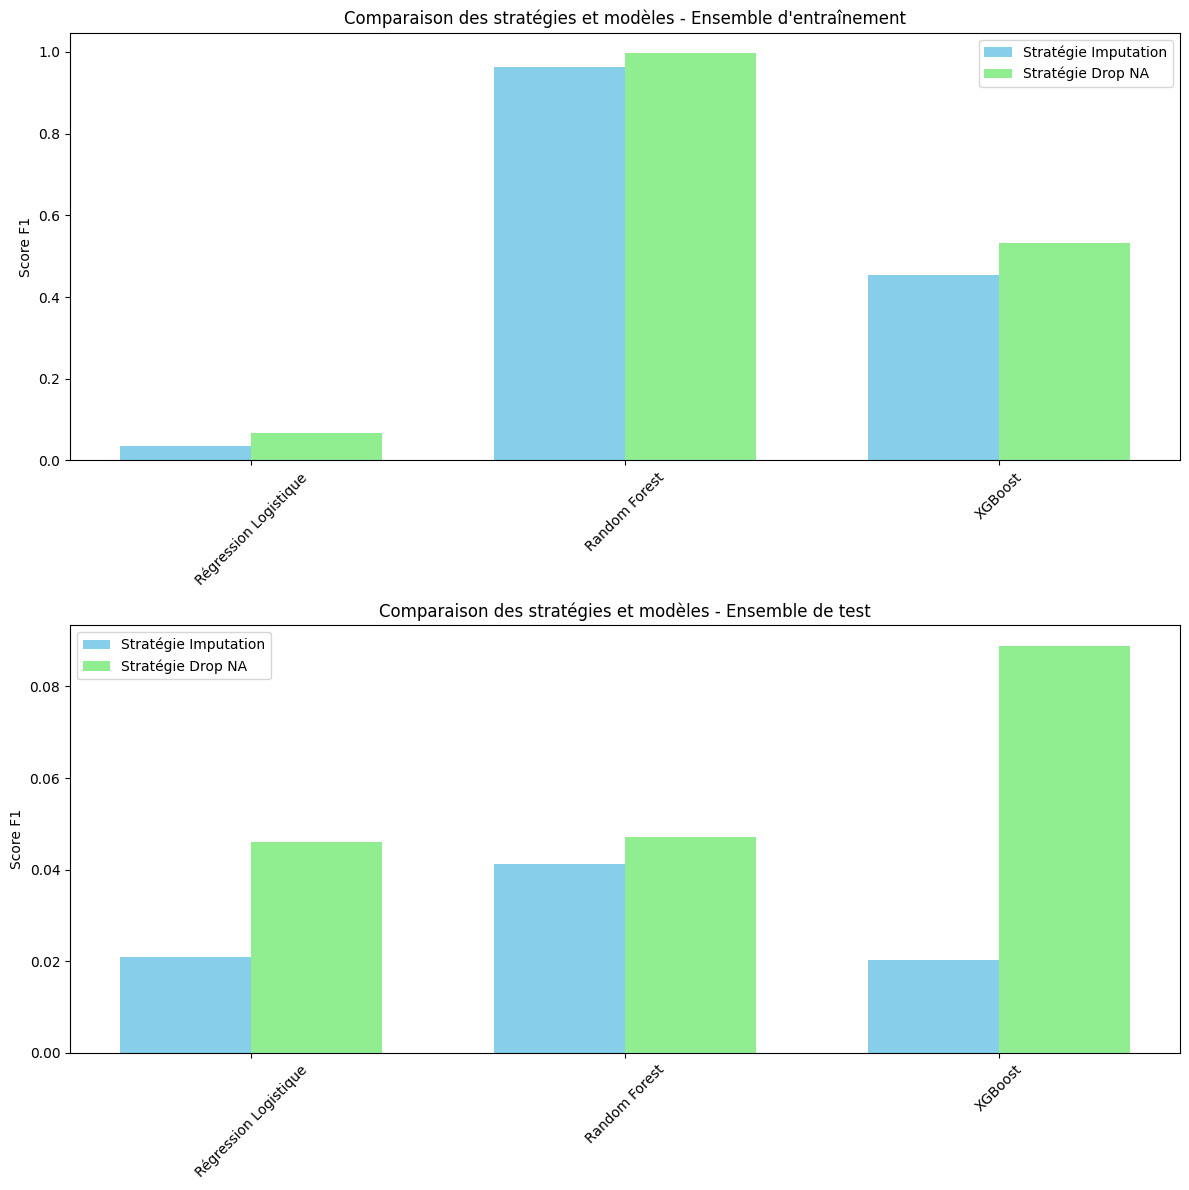

In [9]:
# Cr√©ation des mod√®les
models = {
    'R√©gression Logistique': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Dictionnaire pour stocker les scores
scores = {
    'Train_Imputation': [],
    'Train_Drop_NA': [],
    'Test_Imputation': [],
    'Test_Drop_NA': []
}

model_names = []

# √âvaluation des mod√®les
for name, model in models.items():
    # Pipeline avec imputation
    pipeline_imp = train_evaluate_model_imputation(model)
    y_pred_train_imp = pipeline_imp.predict(X_train)
    y_pred_test_imp = pipeline_imp.predict(X_test)
    scores['Train_Imputation'].append(f1_score(y_train, y_pred_train_imp))
    scores['Test_Imputation'].append(f1_score(y_test, y_pred_test_imp))
    
    # Pipeline avec drop NA
    pipeline_drop = train_evaluate_model_dropna(model)
    y_pred_train_drop = pipeline_drop.predict(X_train_dropna)
    y_pred_test_drop = pipeline_drop.predict(X_test_dropna)
    scores['Train_Drop_NA'].append(f1_score(y_train_dropna, y_pred_train_drop))
    scores['Test_Drop_NA'].append(f1_score(y_test_dropna, y_pred_test_drop))
    
    model_names.append(name)

# Cr√©ation des graphiques de comparaison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

x = np.arange(len(model_names))
width = 0.35

# Graphique pour les scores d'entra√Ænement
ax1.bar(x - width/2, scores['Train_Imputation'], width, label='Strat√©gie Imputation', color='skyblue')
ax1.bar(x + width/2, scores['Train_Drop_NA'], width, label='Strat√©gie Drop NA', color='lightgreen')
ax1.set_ylabel('Score F1')
ax1.set_title('Comparaison des strat√©gies et mod√®les - Ensemble d\'entra√Ænement')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Graphique pour les scores de test
ax2.bar(x - width/2, scores['Test_Imputation'], width, label='Strat√©gie Imputation', color='skyblue')
ax2.bar(x + width/2, scores['Test_Drop_NA'], width, label='Strat√©gie Drop NA', color='lightgreen')
ax2.set_ylabel('Score F1')
ax2.set_title('Comparaison des strat√©gies et mod√®les - Ensemble de test')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [10]:
# Enregistrement des r√©sultats dans MLflow
import mlflow

# Configuration MLflow
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
mlflow.set_experiment("HPP_Prediction_Imputation_Strategy")
experiment = mlflow.get_experiment_by_name("HPP_Prediction_Imputation_Strategy")

client = mlflow.tracking.MlflowClient()

# Pour chaque mod√®le et chaque strat√©gie
for i, model_name in enumerate(model_names):
    # Run pour la strat√©gie d'imputation
    run_imp = client.create_run(experiment.experiment_id, run_name=f"{model_name}_imputation")
    with mlflow.start_run(run_id=run_imp.info.run_id) as run:
        mlflow.sklearn.autolog()
        
        # Logging des m√©triques
        mlflow.log_metric("train_score", scores['Train_Imputation'][i])
        mlflow.log_metric("test_score", scores['Test_Imputation'][i])
        
        # Logging des param√®tres
        mlflow.log_param("strategie", "imputation")
        mlflow.log_param("model", model_name)
        mlflow.log_param("metrique", "F1-score")
    
    # Run pour la strat√©gie drop NA
    run_drop = client.create_run(experiment.experiment_id, run_name=f"{model_name}_dropna")
    with mlflow.start_run(run_id=run_drop.info.run_id) as run:
        mlflow.sklearn.autolog()
        
        # Logging des m√©triques
        mlflow.log_metric("train_score", scores['Train_Drop_NA'][i])
        mlflow.log_metric("test_score", scores['Test_Drop_NA'][i])
        
        # Logging des param√®tres
        mlflow.log_param("strategie", "dropna")
        mlflow.log_param("model", model_name)
        mlflow.log_param("metrique", "F1-score")

# Sauvegarde des graphiques de comparaison dans un run s√©par√©
run_viz = client.create_run(experiment.experiment_id, run_name="visualisation_comparaison")
with mlflow.start_run(run_id=run_viz.info.run_id) as run:
    # Sauvegarde des graphiques
    plt.figure(fig.number)
    mlflow.log_figure(fig, "comparaison_strategies.png")
    
    # Cr√©ation et sauvegarde du DataFrame r√©capitulatif
    resultats_df = pd.DataFrame({
        'Modele': model_names,
        'Train_Score_Imputation': scores['Train_Imputation'],
        'Test_Score_Imputation': scores['Test_Imputation'],
        'Train_Score_DropNA': scores['Train_Drop_NA'],
        'Test_Score_DropNA': scores['Test_Drop_NA']
    })
    
    # Sauvegarde du DataFrame
    resultats_df.to_csv("resultats_comparaison.csv")
    mlflow.log_artifact("resultats_comparaison.csv")
    
    # Logging des param√®tres g√©n√©raux
    mlflow.log_param("nombre_modeles", len(model_names))
    mlflow.log_param("modeles_testes", ", ".join(model_names))


üèÉ View run R√©gression Logistique_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/5dab463ad797486e9579643d3f71a8b6
üß™ View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
üèÉ View run R√©gression Logistique_dropna at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/84df3cb80aed459f8f847d3008ada82b
üß™ View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
üèÉ View run Random Forest_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/a61aba8558914797980b3be735fb6ed7
üß™ View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
üèÉ View run Random Forest_dropna at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/4503dd2fa06c46d28115691c20b39454
üß™ View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
üèÉ View run XGBoost_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/d156c95edfdc4b208ed6744a5da9c

<Figure size 640x480 with 0 Axes>

### Notre analyse comparative r√©v√®le que l'approche de suppression des observations avec valeurs manquantes (dropna) offre de meilleures performances que la strat√©gie d'imputation. Nous avons donc retenu cette m√©thode pour la suite du projet.
### 
### Cette d√©cision comporte n√©anmoins des implications importantes pour le d√©ploiement de notre outil pr√©dictif. Les donn√©es nouvellement charg√©es dans l'application de pr√©diction devront √™tre compl√®tes, sans valeurs manquantes, sous peine d'√™tre exclues de l'analyse. Cela n√©cessite un travail consid√©rable de sensibilisation aupr√®s des utilisateurs pour garantir la collecte exhaustive des variables. Par ailleurs, une r√©flexion approfondie s'impose sur la s√©lection des variables les plus pertinentes pour la pr√©diction. Il pourrait √™tre judicieux de r√©duire leur nombre en ne conservant que les plus significatives, facilitant ainsi la collecte de donn√©es compl√®tes. Cette s√©lection devra √©galement tenir compte de l'influence des variables sur les diff√©rents mod√®les.